In [1]:
# --- Clean + Join HK Mini-Storage (robust version) ---

import pandas as pd, re, html

# 1) Load
fac = pd.read_csv("Source A.csv", encoding="utf-8")      # Buildings Dept list
pop = pd.read_csv("Source B.csv", encoding="utf-8")      # Population table

# 2) Select needed columns
# Source A: column K = district (11th col -> index 10)
fac = fac.iloc[:, [10]].copy()
fac.columns = ["district_raw"]

# Source B: col A = district (index 0), col D = population (index 3)
pop = pop.iloc[:, [0, 3]].copy()
pop.columns = ["district_raw", "population_raw"]

# 3) Normalization helper
def norm_district(s: str) -> str:
    if pd.isna(s): return None
    s = str(s).strip()
    s = html.unescape(s)              # turn "&amp;" -> "&"
    s = re.sub(r"\s+", " ", s)        # collapse whitespace
    s = re.sub(r"\s*區$", "", s)      # remove trailing Chinese "區" if present
    s = s.replace(" DISTRICT", "")    # remove trailing " DISTRICT"
    s = s.title()                     # Title Case: "KWAI TSING" -> "Kwai Tsing"
    s = s.replace(" And ", " & ")     # "Central And Western" -> "Central & Western"
    # Fix a few known variations
    fixes = {
        "Yau Tsim Mong District": "Yau Tsim Mong",
        "Central & Western District": "Central & Western",
        "Kwun Tong District": "Kwun Tong",
        "Kowloon City District": "Kowloon City",
        "Wong Tai Sin District": "Wong Tai Sin",
        "Tsuen Wan District": "Tsuen Wan",
        "Kwai Tsing District": "Kwai Tsing",
        "Sai Kung District": "Sai Kung",
        "Tai Po District": "Tai Po",
        "Tuen Mun District": "Tuen Mun",
        "Yuen Long District": "Yuen Long",
        "Islands District": "Islands",
        "Eastern District": "Eastern",
        "Southern District": "Southern",
        "Wan Chai District": "Wan Chai",
        "North District": "North",
        "Sham Shui Po District": "Sham Shui Po"
    }
    return fixes.get(s, s)

# 4) Apply normalization
fac["district"] = fac["district_raw"].map(norm_district)
pop["district"] = pop["district_raw"].map(norm_district)

# 5) Aggregate facilities by district (one row per district)
fac_agg = (
    fac.dropna(subset=["district"])
       .groupby("district", as_index=False)
       .size()
       .rename(columns={"size": "facility_count"})
)

# 6) Clean population
pop["population"] = pd.to_numeric(pop["population_raw"], errors="coerce") * 1000

# 7) Join
merged = fac_agg.merge(pop[["district", "population"]], on="district", how="left")

# 8) Diagnostics
unmatched = merged[merged["population"].isna()]["district"].unique().tolist()
print("Unmatched districts after join:", unmatched)

# 9) Compute per-capita metric
merged["facilities_per_100k"] = (merged["facility_count"] / merged["population"] * 100000).round(2)

# 10) Save outputs
fac_agg.to_csv("facilities_by_district.csv", index=False, encoding="utf-8-sig")
merged.to_csv("mini_storage_joined.csv", index=False, encoding="utf-8-sig")

print("✅ Saved: facilities_by_district.csv, mini_storage_joined.csv")

# Quick preview
merged.sort_values("facilities_per_100k", ascending=False).head(10)


Unmatched districts after join: []
✅ Saved: facilities_by_district.csv, mini_storage_joined.csv


,district,facility_count,population,facilities_per_100k
1,Eastern,103,514400.0,20.02
0,Central & Western,40,229400.0,17.44
10,Tsuen Wan,53,306200.0,17.31
8,Southern,41,254700.0,16.10
3,Kwai Tsing,58,491600.0,11.80
4,Kwun Tong,56,662400.0,8.45
2,Kowloon City,30,412500.0,7.27
6,Sha Tin,48,698900.0,6.87
12,Wong Tai Sin,27,406700.0,6.64
7,Sham Shui Po,27,432300.0,6.25


/tmp/ipython-input-995881259.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='district', y='facilities_per_100k', data=plot_data, palette='viridis')


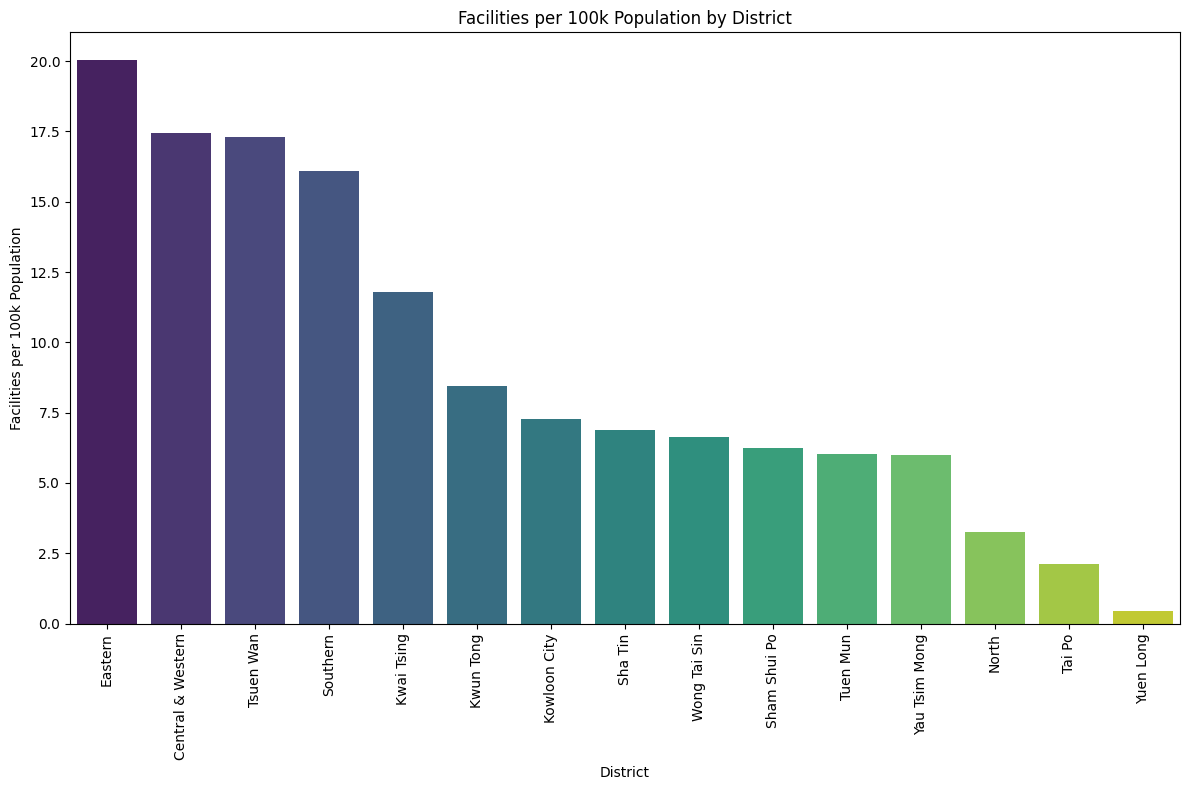

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort the merged DataFrame by 'facilities_per_100k' in descending order
plot_data = merged.sort_values('facilities_per_100k', ascending=False)

plt.figure(figsize=(12, 8))
sns.barplot(x='district', y='facilities_per_100k', data=plot_data, palette='viridis')
plt.title('Facilities per 100k Population by District')
plt.xlabel('District')
plt.ylabel('Facilities per 100k Population')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [3]:
import pandas as pd, sqlite3, os, csv

# --- Load inputs ---
fac = pd.read_csv("facilities_by_district.csv", encoding="utf-8")
pop = pd.read_csv("Source B.csv", encoding="utf-8")

# --- Pick population columns (edit if needed) ---
# Try to guess district + population
pop_cols = [c for c in pop.columns]
# crude guess: first text-like col is district, last numeric-like col is population
dist_col = next((c for c in pop_cols if "district" in c.lower() or "area" in c.lower()), pop_cols[0])
num_candidates = [c for c in pop_cols if pd.to_numeric(pop[c], errors="coerce").notna().sum()>5]
pop_col  = num_candidates[-1] if num_candidates else pop_cols[-1]

# Clean population scale (×1000 if it’s in thousands)
pop2 = pop[[dist_col, pop_col]].copy()
pop2.columns = ["district","population"]
pop2["population"] = pd.to_numeric(pop2["population"], errors="coerce")
if pop2["population"].median() < 2000:
    pop2["population"] = pop2["population"] * 1000

# Keep only districts in facilities_by_district to avoid noise
fac["district"] = fac["district"].astype(str).str.strip()
pop2["district"] = pop2["district"].astype(str).str.strip()
pop2 = pop2[pop2["district"].isin(fac["district"].unique())].copy()

# --- Build SQLite DB ---
db_path = "hk_ministorage.db"
if os.path.exists(db_path): os.remove(db_path)
con = sqlite3.connect(db_path)

fac.to_sql("facilities_by_district", con, index=False)
pop2.to_sql("population_by_district", con, index=False)

# Create a clean joined view
con.execute("DROP VIEW IF EXISTS v_facilities_per_capita;")
con.execute("""
CREATE VIEW v_facilities_per_capita AS
SELECT
  f.district,
  f.facility_count,
  p.population,
  ROUND(100000.0 * f.facility_count / p.population, 2) AS facilities_per_100k
FROM facilities_by_district f
JOIN population_by_district p ON p.district = f.district
""")
con.commit()

# Preview
df = pd.read_sql_query("SELECT * FROM v_facilities_per_capita ORDER BY facilities_per_100k DESC;", con)
df.to_csv("sql_output_facilities_per_capita.csv", index=False, encoding="utf-8-sig")
con.close()

print("✅ Created hk_ministorage.db and sql_output_facilities_per_capita.csv")
print("District column (population file) guessed as:", dist_col)
print("Population column guessed as:", pop_col)
df.head()


✅ Created hk_ministorage.db and sql_output_facilities_per_capita.csv
District column (population file) guessed as: Table 1.1 : Land-based non-institutional population by District Council district and sex
Population column guessed as: Unnamed: 3


,district,facility_count,population,facilities_per_100k
0,Eastern,103,514400.0,20.02
1,Tsuen Wan,53,306200.0,17.31
2,Southern,41,254700.0,16.10
3,Kwai Tsing,58,491600.0,11.80
4,Kwun Tong,56,662400.0,8.45


In [4]:
import sqlite3
import pandas as pd

# connect to your local SQLite DB
con = sqlite3.connect("hk_ministorage.db")

In [5]:
query = """
SELECT
  f.district,
  f.facility_count,
  p.population,
  ROUND(100000.0 * f.facility_count / p.population, 2) AS facilities_per_100k
FROM facilities_by_district f
JOIN population_by_district p
  ON p.district = f.district
ORDER BY facilities_per_100k DESC;
"""

df = pd.read_sql_query(query, con)
df



,district,facility_count,population,facilities_per_100k
0,Eastern,103,514400.0,20.02
1,Tsuen Wan,53,306200.0,17.31
2,Southern,41,254700.0,16.10
3,Kwai Tsing,58,491600.0,11.80
4,Kwun Tong,56,662400.0,8.45
5,Kowloon City,30,412500.0,7.27
6,Sha Tin,48,698900.0,6.87
7,Wong Tai Sin,27,406700.0,6.64
8,Sham Shui Po,27,432300.0,6.25
9,Tuen Mun,32,531000.0,6.03


In [6]:
pd.read_sql_query("""
SELECT district, facility_count
FROM facilities_by_district
ORDER BY facility_count DESC
LIMIT 5;
""", con)

,district,facility_count
0,Eastern,103
1,Kwai Tsing,58
2,Kwun Tong,56
3,Tsuen Wan,53
4,Sha Tin,48


In [7]:
pd.read_sql_query("""
WITH d AS (
  SELECT f.district,
         100000.0 * f.facility_count / p.population AS per100k
  FROM facilities_by_district f
  JOIN population_by_district p ON p.district = f.district
),
avgd AS (SELECT AVG(per100k) AS avg_per100k FROM d)
SELECT d.district, ROUND(d.per100k,2) AS facilities_per_100k
FROM d, avgd
WHERE d.per100k < avgd.avg_per100k
ORDER BY d.per100k ASC;
""", con)

,district,facilities_per_100k
0,Yuen Long,0.45
1,Tai Po,2.13
2,North,3.25
3,Yau Tsim Mong,6.01
4,Tuen Mun,6.03
5,Sham Shui Po,6.25
6,Wong Tai Sin,6.64
7,Sha Tin,6.87
8,Kowloon City,7.27
9,Kwun Tong,8.45


In [8]:
df.to_csv("sql_result.csv", index=False, encoding="utf-8-sig")

In [9]:
con.close()


<Axes: xlabel='district'>

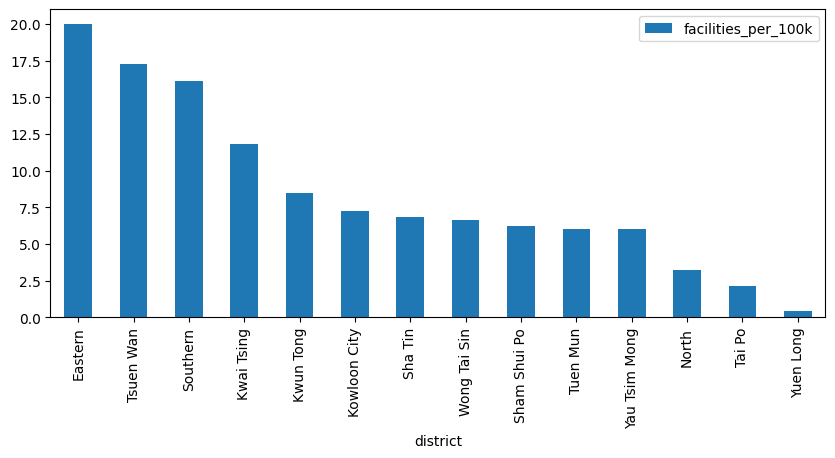

In [10]:
df.plot(kind="bar", x="district", y="facilities_per_100k", figsize=(10,4))

In [11]:
import sqlite3
import pandas as pd

# --- Connect to your SQLite database ---
con = sqlite3.connect("hk_ministorage.db")

# --- Query 1: Full join + metric (facilities per 100k) ---
q1 = """
SELECT
  f.district,
  f.facility_count,
  p.population,
  ROUND(100000.0 * f.facility_count / p.population, 2) AS facilities_per_100k
FROM facilities_by_district f
JOIN population_by_district p ON p.district = f.district
ORDER BY facilities_per_100k DESC;
"""
df1 = pd.read_sql_query(q1, con)
df1.to_csv("sql_result_facilities_per_100k.csv", index=False, encoding="utf-8-sig")

# --- Query 2: Top 5 districts by facility count ---
q2 = """
SELECT district, facility_count
FROM facilities_by_district
ORDER BY facility_count DESC
LIMIT 5;
"""
df2 = pd.read_sql_query(q2, con)
df2.to_csv("sql_result_top5.csv", index=False, encoding="utf-8-sig")

# --- Query 3: Districts below average facilities per 100k ---
q3 = """
WITH d AS (
  SELECT
    f.district,
    100000.0 * f.facility_count / p.population AS per100k
  FROM facilities_by_district f
  JOIN population_by_district p ON p.district = f.district
),
avgd AS (SELECT AVG(per100k) AS avg_per100k FROM d)
SELECT d.district, ROUND(d.per100k,2) AS facilities_per_100k
FROM d, avgd
WHERE d.per100k < avgd.avg_per100k
ORDER BY d.per100k ASC;
"""
df3 = pd.read_sql_query(q3, con)
df3.to_csv("sql_result_below_avg.csv", index=False, encoding="utf-8-sig")

# --- Print summary ---
print("✅ All SQL queries executed successfully!")
print("Saved files:")
print(" - sql_result_facilities_per_100k.csv")
print(" - sql_result_top5.csv")
print(" - sql_result_below_avg.csv")

# --- Optional: show preview ---
print("\n--- Top 5 Districts ---")
display(df2)
print("\n--- Below Average Districts ---")
display(df3)

✅ All SQL queries executed successfully!
Saved files:
 - sql_result_facilities_per_100k.csv
 - sql_result_top5.csv
 - sql_result_below_avg.csv

--- Top 5 Districts ---


,district,facility_count
0,Eastern,103
1,Kwai Tsing,58
2,Kwun Tong,56
3,Tsuen Wan,53
4,Sha Tin,48



--- Below Average Districts ---


,district,facilities_per_100k
0,Yuen Long,0.45
1,Tai Po,2.13
2,North,3.25
3,Yau Tsim Mong,6.01
4,Tuen Mun,6.03
5,Sham Shui Po,6.25
6,Wong Tai Sin,6.64
7,Sha Tin,6.87
8,Kowloon City,7.27
9,Kwun Tong,8.45
